# DDQN with Space Invaders using T-F Agents

In [1]:
# Bit of formatting because inline code is not styled very good by default:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

In [2]:
# Get necessary libraries
from __future__ import absolute_import, division, print_function

import gym
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

from skimage import transform 
from skimage.color import rgb2gray

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()

## Step 1: Create Environment from OpenAI Retro
Note: Need to download <a href="http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html">Atari ROM</a> before initializing gym environment



Command Line to Import ROM: python -m retro.import ./path/to/your/ROMs/directory/

In [3]:
env_name = "SpaceInvaders-v0"
ATARI_FRAME_SKIP = 4
max_episode_frames=108000

env = gym.make(env_name)
env.reset()                    

print("Action space: ", env.action_space.n)
print("Observation space: ", env.observation_space)

Action space:  6
Observation space:  Box(210, 160, 3)


## Step 2: Define Preprocessing Functions
- RGB to Grayscale
- Crop Frame
- Normalize Pixel Values
- Resize Frame

In [4]:
def preprocess_frame(image, new_size=(105, 80)):
    # convert to greyscale, resize and normalize the image
    #image = tf.image.rgb_to_grayscale(image)
    #image = tf.image.resize(image, new_size)
    image = tf.cast(image, tf.float32)
    image = image / 255
    return image

## Step 3: Convert Environment to Tensors

In [5]:
train_py_env = suite_atari.load(
                env_name,
                max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
                gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
eval_py_env = suite_atari.load(
                env_name,
                max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
                gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

# train_py_env = suite_atari.load(env_name)
# eval_py_env = suite_atari.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Step 4: Set Hyperparameters

In [6]:
num_iterations = 80000 

initial_collect_steps = 1000 
collect_steps_per_iteration = 1  
replay_buffer_max_length = 100000 

batch_size = 64  
learning_rate = 1e-3  
log_interval = 1000  

num_eval_episodes = 10  
eval_interval = 5000 

## Step 5: Define Q Network

In [7]:
class AtariQNetwork(q_network.QNetwork):
  """QNetwork subclass that divides observations by 255."""

  def call(self,
           observation,
           step_type=None,
           network_state=(),
           training=False):
    state = preprocess_frame(observation)
    return super(AtariQNetwork, self).call(
        state, step_type=step_type, network_state=network_state,
        training=training)

fc_layer_params = (512,128,)
conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (2, 2), 1))

q_net = AtariQNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params)

## Step 5: Initialize Agent

In [8]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

target_update_period=32000  
update_period=16 
_update_period = update_period / ATARI_FRAME_SKIP

agent = dqn_agent.DdqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    gamma=0.9,
    epsilon_greedy=0.01,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period))

agent.initialize()

In [9]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

## Step 6: Metrics and Evaluation

In [10]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

compute_avg_return(eval_env, random_policy, num_eval_episodes)

90.5

## Step 7: Replay Buffer

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

## Step 8: Data Collection

In [12]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=initial_collect_steps)

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

## Step 9: Train Agent

In [13]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 1000: loss = 0.5647948384284973
step = 2000: loss = 0.3375473618507385
step = 3000: loss = 0.324654221534729
step = 4000: loss = 0.8067251443862915
step = 5000: loss = 0.2518162429332733
step = 5000: Average Return = 166.5
step = 6000: loss = 1.408919334411621
step = 7000: loss = 0.8782541751861572
step = 8000: loss = 0.219059556722641
step = 9000: loss = 0.6298201084136963
step = 10000: loss = 1.072961688041687
step = 10000: Average Return = 174.5
step = 11000: loss = 0.4606621265411377
step = 12000: loss = 0.48309841752052307
step = 13000: loss = 0.40083879232406616
step = 14000: loss = 0.48427820205688477
step = 15000: loss = 1.1323111057281494
step = 15000: Average Return = 204.5
step = 16000: loss = 0.8123086094856262
step = 17000: loss = 0.9130280613899231
step = 18000: loss = 0.6582978963851929
step = 19000: loss = 0.7043354511260986
step = 20000: loss = 0.842153787612915
step = 20000: Average Return = 192.5
step = 21000: loss = 0.6523454785346985
step = 22000: loss = 0.6

## Step 10: Visualize

(-17.425, 400.0)

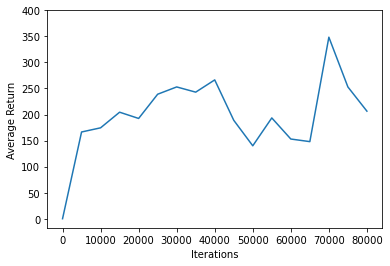

In [19]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=400)

In [15]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="160" height="224" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)


create_policy_eval_video(agent.policy, "trained-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [16]:
create_policy_eval_video(random_policy, "random-agent")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
